# Start kit for Task 2 - Motor imagery decoding transfer learning challenge


We recommand you to read the 'LeaderboardDataGuide' and visit the https://beetl.ai to get familar with data and tasks before you read this start kit.

<p> &#10071; <b>Important</b> &#10071; </p>
For the competition, please MAKE SURE that your model and uploaded labels are reproducible. We will run winner's code and generate the label to compare with the uploaded labels.


## Objective of the tutorial

In this start kit, we will show how to use [MOABB](http://moabb.neurotechx.com/docs/index.html) to load `BNCI2014001`, `Cho2017` and `PhysionetMI` motor imagery datasets for the cross-dataset and cross-subject challenge. We also show an example pipeline of the challenge including:

- Environment setup
- Source motor imagery datasets loading
- Source and target domain data organisation
- Training and evaluation procedure using an example shallow CNN, using [BrainDecode](https://braindecode.org)

References:

> <p>&#128218;  Schirrmeister, Robin Tibor, et al. "Deep learning with convolutional neural networks for EEG decoding and visualization." Human brain mapping 38.11 (2017): 5391-5420. </p>

## Environment Setup

1. Install pytorch from http://pytorch.org/ (you don't need to install torchvision).
1. Install MOABB with pip: `pip install moabb`
1. Install latest release of braindecode via pip: `pip install braindecode`
1. You will also need mne, matplotlib, scikit-learn and pandas
1. If you want to automatically download the data, you could install the helper code with `pip install git+https://github.com/sylvchev/beetl-competition`

Let's import packages and set random seed. 

In [2]:
%matplotlib inline

In [3]:
from braindecode.util import set_random_seeds, np_to_var, var_to_np
import matplotlib.pyplot as plt
from moabb.datasets import BNCI2014001, Cho2017, PhysionetMI
from moabb.paradigms import MotorImagery
import numpy as np
from numpy.random import RandomState
import pickle
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import mne

import util.shallow_net
from util.utilfunc import get_balanced_batches
from util.preproc import plot_confusion_matrix

cuda = torch.cuda.is_available()
print('gpu: ', cuda)
device = 'cuda' if cuda else 'cpu'

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
rng = RandomState(seed)

gpu:  True


To download source MI datasets, we will use MOABB. By default, the datasets are downloaded in a `mne_data` folder in your home directory. To change this default repository, uncomment the next lines of codes and indicate the chosen path.

In [4]:
# from moabb.utils import set_download_dir
# set_download_dir("/path/to/my/datasets")

The next blocks download the data from the first subject of `BNCI2014001`, `Cho2017`, `PhysionetMI` and print information regarding the data.

In [5]:
subj = 1
for dataset in [BNCI2014001(), PhysionetMI(), Cho2017()]:
    data = dataset.get_data(subjects=[subj])
    ds_name = dataset.code
    ds_type = dataset.paradigm
    sess = 'session_T' if ds_name == "001-2014" else 'session_0'
    run = sorted(data[subj][sess])[0]
    ds_ch_names = data[subj][sess][run].info['ch_names']  # [0:22]
    ds_sfreq = data[subj][sess][run].info['sfreq']
    print("{} is an {} dataset, acquired at {} Hz, with {} electrodes\nElectrodes names: ".format(ds_name, ds_type, ds_sfreq, len(ds_ch_names)))
    print(ds_ch_names)
    print()

001-2014 is an imagery dataset, acquired at 250.0 Hz, with 26 electrodes
Electrodes names: 
['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz', 'EOG1', 'EOG2', 'EOG3', 'stim']

Physionet Motor Imagery is an imagery dataset, acquired at 160.0 Hz, with 64 electrodes
Electrodes names: 
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']



Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


Cho2017 is an imagery dataset, acquired at 512.0 Hz, with 69 electrodes
Electrodes names: 
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'Stim']



# Loading MI Data

We will use the first 3 subjects of `Cho2017` and first 5 subjects of `PhysionetMI` as the source data and we will use the first subject from `BNCI2014001` as the target subject we would like to transfer to. We directly regard trials other than left/right hand MI as 'other' and train them together, you could come up with your own strategy for this transfering like from rest to tongue or so.

Note here that the data labels are not balanced, and cross dataset transfer learning is still a challenge in the literature (with different channel sizes, sampling rate, window length even hardware for data collection sometimes). Here is just an example adding the calibration target samples into the training pool, which is just an example yet not a 'solution'. Please come up with your own strategies.

To summarize, we will split the data as such:

- training: source data from subjects 1, 2, 3 of `Cho2017` (only left- and right-hand) and subjects 1, 2, 3, 4, 5 from `PhysionetMI` (left-hand, right-hand and 'other'), and the first 100 trials from subject 1 of target dataset `BNCI2014001` (left-hand, right-hand and 'other')
- validation: 50 trials from subject 1 of `BNCI2014001` with left-hand, right-hand and 'other'.
- test: the rest of the trials from subject 1 of `BNCI2014001`, as target data, with left-hand, right-hand and 'other'.

First, lets get the data using correct bandpass filter, resampling and electrode selection to match target domain. Here we simply selected the common electrodes as an example, you could come up with your own channel transfer strategies.

In [6]:
ds_src1 = Cho2017()
ds_src2 = PhysionetMI()
ds_tgt = BNCI2014001()

fmin, fmax = 4, 32
raw = ds_tgt.get_data(subjects=[1])[1]['session_T']['run_1']
tgt_channels = raw.pick_types(eeg=True).ch_names
sfreq = 250.
prgm_2classes = MotorImagery(n_classes=2, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)
prgm_4classes = MotorImagery(n_classes=4, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)

X_src1, label_src1, m_src1 = prgm_2classes.get_data(dataset=ds_src1, subjects=[1, 2, 3])
X_src2, label_src2, m_src2 = prgm_4classes.get_data(dataset=ds_src2, subjects=[1, 2, 3, 4, 5])
X_tgt, label_tgt, m_tgt = prgm_4classes.get_data(dataset=ds_tgt, subjects=[1])

print("First source dataset has {} trials with {} electrodes and {} time samples".format(*X_src1.shape))
print("Second source dataset has {} trials with {} electrodes and {} time samples".format(*X_src2.shape))
print("Target dataset has {} trials with {} electrodes and {} time samples".format(*X_tgt.shape))

print ("\nSource dataset 1 include labels: {}".format(np.unique(label_src1)))
print ("Source dataset 2 include labels: {}".format(np.unique(label_src2)))
print ("Target dataset 1 include labels: {}".format(np.unique(label_tgt)))

Choosing from all possible events
Choosing from all possible events
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


First source dataset has 600 trials with 22 electrodes and 750 time samples
Second source dataset has 450 trials with 22 electrodes and 752 time samples
Target dataset has 576 trials with 22 electrodes and 1001 time samples

Source dataset 1 include labels: ['left_hand' 'right_hand']
Source dataset 2 include labels: ['feet' 'hands' 'left_hand' 'right_hand']
Target dataset 1 include labels: ['feet' 'left_hand' 'right_hand' 'tongue']


As explained above, we will use only left- and right-hand labels, the other labels will be listed as other.

In [7]:
def relabel(l):
    if l == 'left_hand': return 0
    elif l == 'right_hand': return 1
    else: return 2


y_src1 = np.array([relabel(l) for l in label_src1])
y_src2 = np.array([relabel(l) for l in label_src2])
y_tgt = np.array([relabel(l) for l in label_tgt])

print("Only right-/left-hand labels are used and first source dataset does not have other labels:")
print(np.unique(y_src1), np.unique(y_src2), np.unique(y_tgt))

Only right-/left-hand labels are used and first source dataset does not have other labels:
[0 1] [0 1 2] [0 1 2]


In [8]:
window_size = min(X_src1.shape[2], X_src2.shape[2], X_tgt.shape[2])

X_train = np.concatenate((X_src1[:, :, :window_size], X_src2[:, :, :window_size], X_tgt[:100, :, :window_size]))
y_train = np.concatenate((y_src1, y_src2, y_tgt[:100]))

X_val = X_tgt[100:150, :, :window_size]
y_val = y_tgt[100:150]

X_test = X_tgt[150:, :, :window_size]
y_test = y_tgt[150:]

print("Train:  there are {} trials with {} electrodes and {} time samples".format(*X_train.shape))
print("\nValidation: there are {} trials with {} electrodes and {} time samples".format(*X_val.shape))
print("\nTest: there are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

Train:  there are 1150 trials with 22 electrodes and 750 time samples

Validation: there are 50 trials with 22 electrodes and 750 time samples

Test: there are 426 trials with 22 electrodes and 750 time samples


**Warning** 
Data are not normalized and labels are not balanced. Please come up with your strategy.

## Training a CNN

Here, we use a shallow CNN structure as an example, you should replace it with your own algorithm here.

In [9]:
class TrainObject(object):
    def __init__(self, X, y):
        assert len(X) == len(y)
        # Normalised, you could choose other normalisation strategy
        mean = np.mean(X,axis=1,keepdims=True)
        # here normalise across channels as an example, unlike the in the sleep kit
        std = np.std(X, axis=1, keepdims=True)
        X = (X - mean) / std
        # we scale it to 1000 as a better training scale of the shallow CNN
        # according to the orignal work of the paper referenced above
        self.X = X.astype(np.float32) * 1e3
        self.y = y.astype(np.int64)

train_set = TrainObject(X_train, y=y_train)
valid_set = TrainObject(X_val, y=y_val)
test_set = TrainObject(X_test, y=y_test)

In [10]:
in_chans = X_train.shape[1]
labelsize = len(np.unique(y_train))
model = util.shallow_net.EEGShallowClassifier(in_chans, labelsize, window_size, return_feature=False)
if cuda:
    model.cuda()

Epoch 0
Train  Loss: 0.92984
Train  Accuracy: 55.7%
Valid  Loss: 1.20127
Valid  Accuracy: 50.0%
model saved
[[ 1  0 12]
 [ 0  0 13]
 [ 0  0 24]]
Normalized confusion matrix


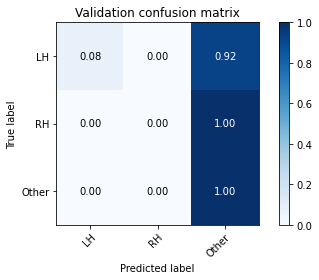

Epoch 1
Train  Loss: 0.82003
Train  Accuracy: 60.6%
Valid  Loss: 1.09654
Valid  Accuracy: 50.0%
model saved
[[ 1  0 12]
 [ 0  0 13]
 [ 0  0 24]]
Normalized confusion matrix


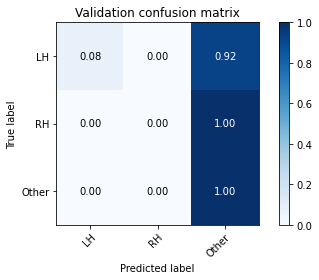

Epoch 2
Train  Loss: 0.74889
Train  Accuracy: 64.8%
Valid  Loss: 1.03304
Valid  Accuracy: 54.0%
model saved
[[ 1  1 11]
 [ 0  2 11]
 [ 0  0 24]]
Normalized confusion matrix


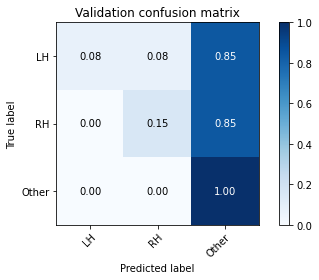

Epoch 3
Train  Loss: 0.69095
Train  Accuracy: 68.5%
Valid  Loss: 0.97502
Valid  Accuracy: 54.0%
model saved
[[ 1  1 11]
 [ 1  2 10]
 [ 0  0 24]]
Normalized confusion matrix


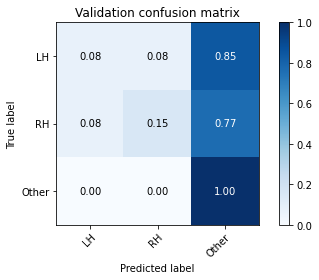

Epoch 4
Train  Loss: 0.64827
Train  Accuracy: 73.2%
Valid  Loss: 0.90847
Valid  Accuracy: 60.0%
model saved
[[ 1  2 10]
 [ 1  5  7]
 [ 0  0 24]]
Normalized confusion matrix


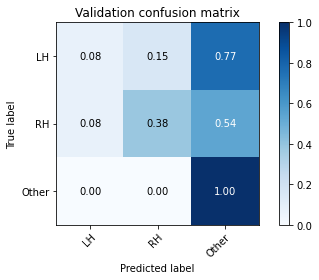

Epoch 5
Train  Loss: 0.59934
Train  Accuracy: 76.9%
Valid  Loss: 0.86258
Valid  Accuracy: 60.0%
model saved
[[ 1  2 10]
 [ 1  5  7]
 [ 0  0 24]]
Normalized confusion matrix


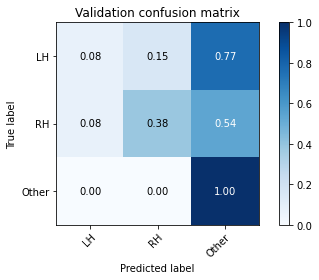

Epoch 6
Train  Loss: 0.55782
Train  Accuracy: 78.3%
Valid  Loss: 0.81291
Valid  Accuracy: 68.0%
model saved
[[ 1  2 10]
 [ 1  9  3]
 [ 0  0 24]]
Normalized confusion matrix


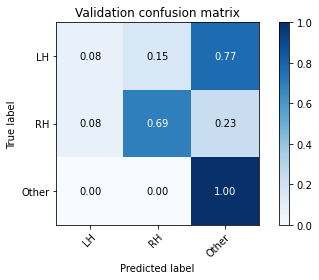

Epoch 7
Train  Loss: 0.52152
Train  Accuracy: 80.0%
Valid  Loss: 0.76841
Valid  Accuracy: 68.0%
model saved
[[ 1  2 10]
 [ 1  9  3]
 [ 0  0 24]]
Normalized confusion matrix


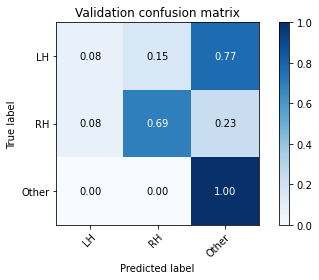

Epoch 8
Train  Loss: 0.49308
Train  Accuracy: 81.7%
Valid  Loss: 0.74473
Valid  Accuracy: 66.0%
Epoch 9
Train  Loss: 0.47524
Train  Accuracy: 83.1%
Valid  Loss: 0.75057
Valid  Accuracy: 72.0%
model saved
[[ 1  2 10]
 [ 0 11  2]
 [ 0  0 24]]
Normalized confusion matrix


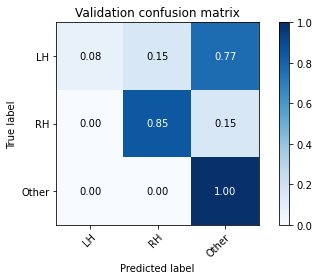

Epoch 10
Train  Loss: 0.42613
Train  Accuracy: 85.4%
Valid  Loss: 0.66754
Valid  Accuracy: 72.0%
model saved
[[ 2  2  9]
 [ 0 11  2]
 [ 1  0 23]]
Normalized confusion matrix


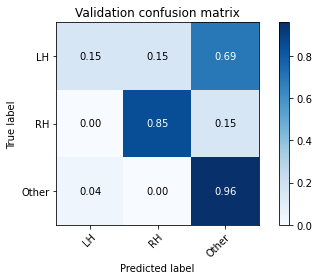

Epoch 11
Train  Loss: 0.40857
Train  Accuracy: 86.3%
Valid  Loss: 0.63414
Valid  Accuracy: 76.0%
model saved
[[ 4  2  7]
 [ 0 11  2]
 [ 1  0 23]]
Normalized confusion matrix


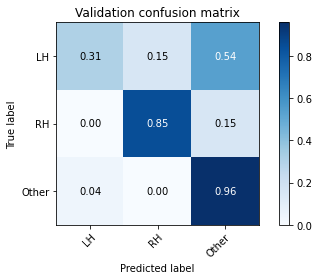

Epoch 12
Train  Loss: 0.37583
Train  Accuracy: 88.5%
Valid  Loss: 0.64845
Valid  Accuracy: 72.0%
Epoch 13
Train  Loss: 0.34762
Train  Accuracy: 90.6%
Valid  Loss: 0.62319
Valid  Accuracy: 72.0%
Epoch 14
Train  Loss: 0.32509
Train  Accuracy: 91.3%
Valid  Loss: 0.62312
Valid  Accuracy: 72.0%
time is 8.619115591049194


In [11]:
batch_size = 60
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.5*0.001)

total_epoch = -1
Tlosses, Taccuracies = [], []
Vlosses, Vaccuracies = [], []
highest_acc = 0

savename = "cnn_model_mi.pth"

start=time.time()
for i_epoch in range(15):
    total_epoch += 1
    # Randomize batches ids and get iterater 'i_trials_in_batch'
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                             batch_size=batch_size)
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X for training
        batch_X = train_set.X[i_trials][:, :, :, None]
        batch_y = train_set.y[i_trials]
        # convert from nparray to torch tensor
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()
    # Set model to evaluation mode
    model.eval()
    print("Epoch {:d}".format(total_epoch))
    average_acc = []
    average_loss = []
    
    # Here we compute training accuracy and validation accuracy of current model
    for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                                 batch_size=60)
        outputs=None
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:, :, :, None]
            batch_y = dataset.y[i_trials]
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            toutputs = model(net_in)
            if outputs is None:
                temp = toutputs.cpu()
                outputs = temp.detach().numpy()
            else:
                temp = toutputs.cpu()
                outputs = np.concatenate((outputs,temp.detach().numpy()))
        net_target = np_to_var(dataset.y)
        loss = F.nll_loss(torch.from_numpy(outputs), net_target)
        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        predicted_labels = np.argmax((outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        
        print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
        if setname == 'Train':
            Tlosses.append(loss)
            Taccuracies.append(accuracy)
            current_Tacc=accuracy
        elif setname == 'Valid':
            Vlosses.append(loss)
            Vaccuracies.append(accuracy)
            if accuracy>=highest_acc:
                torch.save({
                    'in_chans': in_chans,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'n_classes': 3,
                    'input_time_length': window_size
                }, savename)

                highest_acc=accuracy
                print('model saved')
                plot_confusion_matrix(dataset.y, predicted_labels, 
                                      classes=['LH', 'RH', 'Other'], normalize=True,
                                      title='Validation confusion matrix')
                plt.show()
        else:
            average_acc.append(accuracy)
            average_loss.append(accuracy)
end = time.time()

print('time is {}'.format(end-start))

Here we can observe that on training set, the classification accuracy is fairly high, while it is usually not able to generalised well to the new subject directly with this simple strategy, this subject is just a well-performed case for tutorial purpose. Usually validation and test accuracy of a new subject decrease a lot (sometimes 30% or even more). Transfer learning strategies should be used to solve this problem.

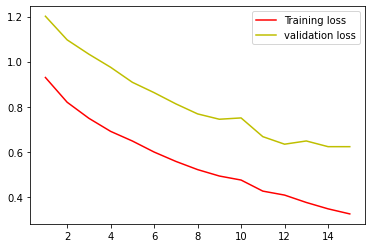

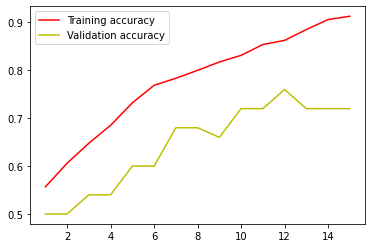

In [12]:
t = np.arange(0.0, len(Tlosses), 1)+1
plt.plot(t, Tlosses, 'r', t, Vlosses, 'y')
plt.legend(('Training loss', 'validation loss'))
plt.show()

plt.plot(t, Taccuracies, 'r', t, Vaccuracies, 'y')
plt.legend(('Training accuracy', 'Validation accuracy'))
plt.show()

testset Loss: 0.64425
testset Accuracy: 74.6%
[[ 45  22  39]
 [ 12  77  17]
 [ 10   8 196]]
Normalized confusion matrix


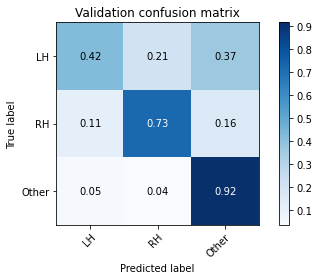

In [13]:
model = util.shallow_net.EEGShallowClassifier(in_chans, labelsize, window_size, return_feature=False)
if cuda:
    model.cuda()
checkpoint = torch.load(savename)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

average_acc, average_loss = [], []
setname = 'testset'
dataset = test_set

i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                         batch_size=30)
outputs=None
for i_trials in i_trials_in_batch:
    # Have to add empty fourth dimension to X
    batch_X = dataset.X[i_trials][:, :, :, None]
    batch_y = dataset.y[i_trials]
    net_in = np_to_var(batch_X)
    if cuda:
        net_in = net_in.cuda()
    toutputs = model(net_in)
    if outputs is None:
        temp = toutputs.cpu()
        outputs = temp.detach().numpy()
    else:
        temp = toutputs.cpu()
        outputs = np.concatenate((outputs,temp.detach().numpy()))

net_target = np_to_var(dataset.y)
loss = F.nll_loss(torch.from_numpy(outputs), net_target)
print("{:6s} Loss: {:.5f}".format(setname, float(var_to_np(loss))))
predicted_labels = np.argmax((outputs), axis=1)
accuracy = np.mean(dataset.y  == predicted_labels)

print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
plot_confusion_matrix(dataset.y, predicted_labels, 
                      classes=['LH','RH','Other'], normalize=True,
                      title='Validation confusion matrix')
plt.show()